In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.7 MB/s eta 0:00:00


 **Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, ChebConv, GatedGraphConv, GATConv
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics.pairwise import haversine_distances
import matplotlib.pyplot as plt
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


**Load and Preprocess Data**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Measurement_summary.csv')

df['Measurement date'] = pd.to_datetime(df['Measurement date'])

df = df.sort_values(['Measurement date', 'Station code'])
features = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

time_index = df['Measurement date'].sort_values().unique()
station_index = df['Station code'].unique()
all_combinations = pd.MultiIndex.from_product([time_index, station_index], names=['Measurement date', 'Station code']).to_frame(index=False)
df_filled = pd.merge(all_combinations, df, on=['Measurement date', 'Station code'], how='left')
df_filled.sort_values(['Measurement date', 'Station code'], inplace=True)


pivoted = df_filled.pivot(index='Measurement date', columns='Station code', values=features)
data_array = np.array(pivoted.values).reshape(len(time_index), len(station_index), len(features))
data_array[np.isnan(data_array)] = 0

print(f"Full data shape: {data_array.shape}")


Full data shape: (25906, 25, 6)


In [ ]:
df

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.211993,0.026848,0.028960,0.030261,0.020630,0.009270
25905,2017-01-01 00:00:00,102,"15, Deoksugung-gil, Jung-gu, Seoul, Republic o...",37.564263,126.974676,0.212416,0.027076,0.028960,0.031637,0.021745,0.010229
51810,2017-01-01 00:00:00,103,"136, Hannam-daero, Yongsan-gu, Seoul, Republic...",37.540033,127.004850,0.212204,0.026340,0.028960,0.033012,0.019794,0.011028
77714,2017-01-01 00:00:00,104,"215, Jinheung-ro, Eunpyeong-gu, Seoul, Republi...",37.609823,126.934848,0.212204,0.026493,0.028988,0.022008,0.020630,0.007512
103610,2017-01-01 00:00:00,105,"32, Segeomjeong-ro 4-gil, Seodaemun-gu, Seoul,...",37.593742,126.949679,0.212204,0.026467,0.029017,0.027510,0.022860,0.007192
...,...,...,...,...,...,...,...,...,...,...,...
543892,2019-12-31 23:00:00,121,"14, Sillimdong-gil, Gwanak-gu, Seoul, Republic...",37.487355,126.927102,0.211782,0.026417,0.029277,0.020633,0.008364,0.002717
569797,2019-12-31 23:00:00,122,"16, Sinbanpo-ro 15-gil, Seocho-gu, Seoul, Repu...",37.504547,126.994458,0.211782,0.026543,0.029104,0.019257,0.006970,0.002557
595701,2019-12-31 23:00:00,123,"426, Hakdong-ro, Gangnam-gu, Seoul, Republic o...",37.517528,127.047470,0.211782,0.026340,0.028988,0.020633,0.005576,0.002237
621606,2019-12-31 23:00:00,124,"236, Baekjegobun-ro, Songpa-gu, Seoul, Republi...",37.502686,127.092509,0.211782,0.026239,0.029017,0.020633,0.005854,0.002237


**Build Graph Adjacency Matrix**

In [ ]:
#unique stations and their coordinates
stations = df[['Station code', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
coords = np.radians(stations[['Latitude', 'Longitude']].values)


dist_matrix = haversine_distances(coords) * 6371

# Create adjacency matrix based on inverse distance
adj_matrix = 1 / (dist_matrix + 1e-6)
np.fill_diagonal(adj_matrix, 0)


A_tensor = torch.tensor(adj_matrix, dtype=torch.float32).to(device)
edge_index = A_tensor.nonzero(as_tuple=False).t()
edge_weight = A_tensor[edge_index[0], edge_index[1]]

print(f"Number of stations (nodes): {A_tensor.size(0)}")


Number of stations (nodes): 25


**Create Temporal Sequences and split data**

In [ ]:
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(data_array)

train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# **S2GNN-LSTM**


**Define S2GNN-LSTM Model**

In [ ]:
class S2GNNLayer(nn.Module):
    def __init__(self, in_features, out_features, K):
        super(S2GNNLayer, self).__init__()
        self.chebconv = ChebConv(in_features, out_features, K)
    def forward(self, X, edge_index, edge_weight=None):
        return F.relu(self.chebconv(X, edge_index, edge_weight))

class S2GNN_LSTM(nn.Module):
    def __init__(self, num_nodes, in_features, s2gnn_hidden, lstm_hidden, out_features, K):
        super(S2GNN_LSTM, self).__init__()
        self.s2gnn = S2GNNLayer(in_features, s2gnn_hidden, K)
        self.lstm = nn.LSTM(s2gnn_hidden, lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, out_features)
        self.num_nodes = num_nodes
    def forward(self, X, edge_index, edge_weight=None):
        B, T, N, F = X.size()
        s2gnn_out = []
        for t in range(T):
            s2gnn_t = self.s2gnn(X[:, t, :, :].reshape(B*N, F), edge_index, edge_weight)
            s2gnn_out.append(s2gnn_t.reshape(B, N, -1))
        s2gnn_seq = torch.stack(s2gnn_out, dim=1)
        lstm_in = s2gnn_seq.permute(0, 2, 1, 3).contiguous().reshape(B*N, T, -1)
        lstm_out, _ = self.lstm(lstm_in)
        lstm_last = lstm_out[:, -1, :]
        out = self.fc(lstm_last)
        return out.reshape(B, N, -1)

**Training and evaluation**

In [ ]:
model = S2GNN_LSTM(num_nodes=A_tensor.size(0), in_features=len(features), s2gnn_hidden=32, lstm_hidden=64, out_features=len(features), K=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 50
batch_size = 64

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X, edge_index, edge_weight)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.8f}")

model.eval()
preds = []
with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_preds = model(batch_X_test, edge_index, edge_weight).cpu().numpy()
        preds.append(batch_preds)
preds = np.concatenate(preds, axis=0)

y_true_flat = y_test_tensor.cpu().numpy().flatten()
y_pred_flat = preds.flatten()
mae = mean_absolute_error(y_true_flat, y_pred_flat)
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, y_pred_flat)

print("\n--- S2GNN-LSTM Test Set Evaluation ---")
print(f"MAE: {mae:.8f}, MSE: {mse:.8f}, RMSE: {rmse:.8f}, R²: {r2:.8f}")

Epoch 1, Train Loss: 0.00000527
Epoch 2, Train Loss: 0.00000798
Epoch 3, Train Loss: 0.00000611
Epoch 4, Train Loss: 0.00003969
Epoch 5, Train Loss: 0.00000250
Epoch 6, Train Loss: 0.00006589
Epoch 7, Train Loss: 0.00000319
Epoch 8, Train Loss: 0.00000318
Epoch 9, Train Loss: 0.00000327
Epoch 10, Train Loss: 0.00000242
Epoch 11, Train Loss: 0.00000522
Epoch 12, Train Loss: 0.00000106
Epoch 13, Train Loss: 0.00000319
Epoch 14, Train Loss: 0.00000123
Epoch 15, Train Loss: 0.00000169
Epoch 16, Train Loss: 0.00000205
Epoch 17, Train Loss: 0.00000265
Epoch 18, Train Loss: 0.00006698
Epoch 19, Train Loss: 0.00000284
Epoch 20, Train Loss: 0.00000212
Epoch 21, Train Loss: 0.00000381
Epoch 22, Train Loss: 0.00006551
Epoch 23, Train Loss: 0.00001351
Epoch 24, Train Loss: 0.00001790
Epoch 25, Train Loss: 0.00000186
Epoch 26, Train Loss: 0.00003207
Epoch 27, Train Loss: 0.00000363
Epoch 28, Train Loss: 0.00000189
Epoch 29, Train Loss: 0.00000271
Epoch 30, Train Loss: 0.00000123
Epoch 31, Train Los

**VISUALIZE PREDICTIONS**

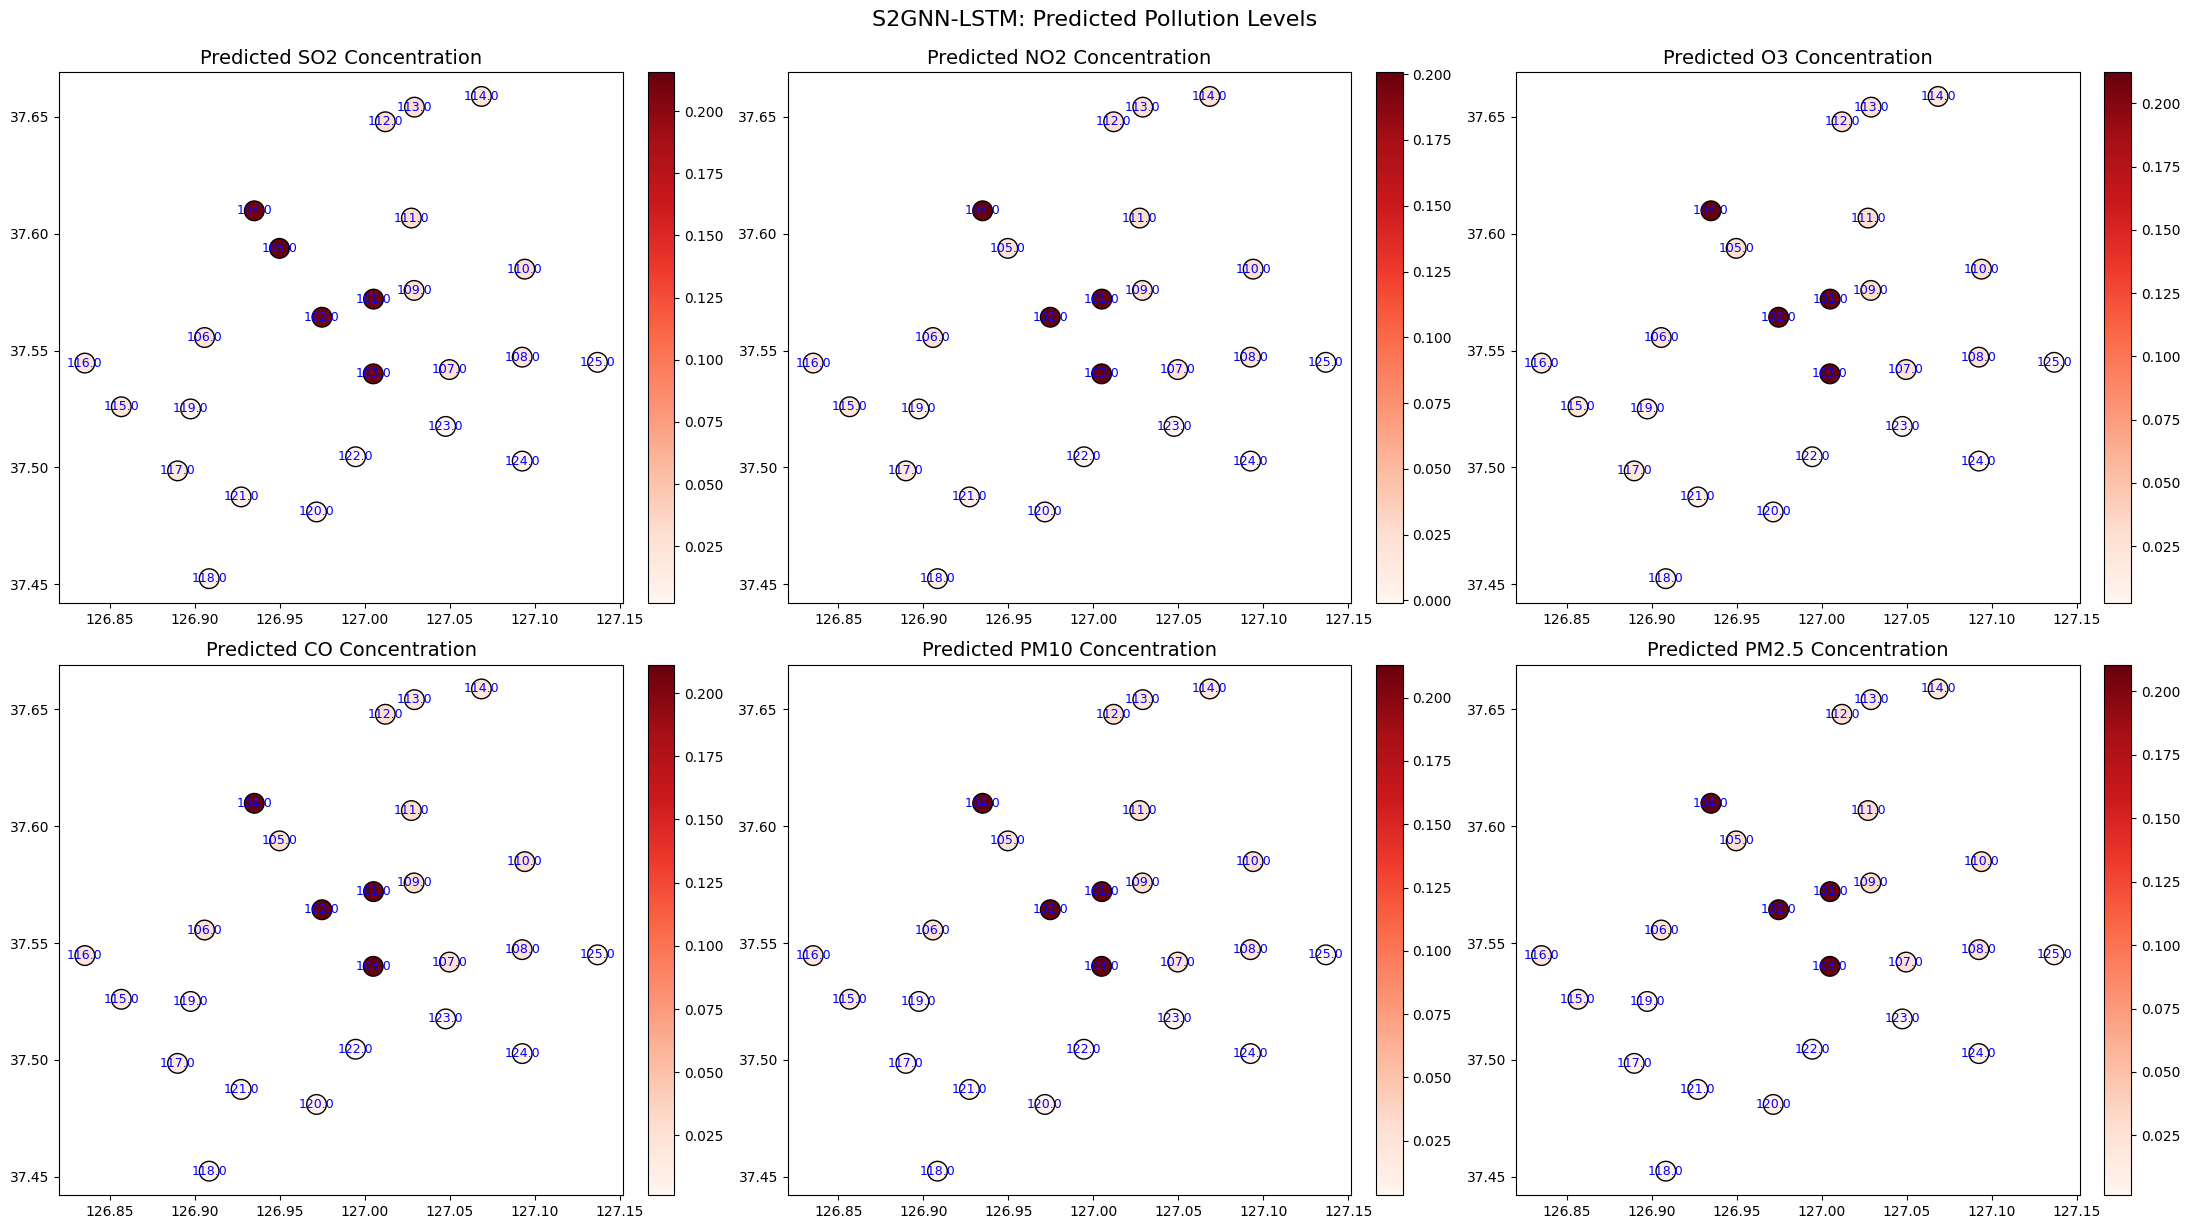

In [ ]:
latest_pred = preds[-1]
pollution_df = stations.copy()
for i, feat in enumerate(features):
    pollution_df[f"{feat}_pred"] = latest_pred[:, i]

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()
for i, feat in enumerate(features):
    ax = axes[i]
    sc = ax.scatter(pollution_df['Longitude'], pollution_df['Latitude'], c=pollution_df[f"{feat}_pred"], cmap='Reds', s=200, edgecolors='k')
    ax.set_title(f'Predicted {feat} Concentration', fontsize=14)
    for idx, row in pollution_df.iterrows():
        ax.text(row['Longitude'], row['Latitude'], str(row['Station code']), fontsize=9, ha='center', va='center', color='blue')
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle("S2GNN-LSTM: Predicted Pollution Levels", fontsize=16, y=1.02)
plt.show()

# S2GNN + Attention

**S2GNN-ATTENTION MODEL DEFINITION**

In [ ]:
class S2GNNLayer(nn.Module):
    def __init__(self, in_features, out_features, K):
        super(S2GNNLayer, self).__init__()
        self.chebconv = ChebConv(in_features, out_features, K)
    def forward(self, X, edge_index, edge_weight=None):
        return F.relu(self.chebconv(X, edge_index, edge_weight))

class S2GNN_Attention(nn.Module):
    def __init__(self, num_nodes, in_features, s2gnn_hidden, gat_hidden, out_features, K, heads=4):
        super(S2GNN_Attention, self).__init__()
        self.s2gnn = S2GNNLayer(in_features, s2gnn_hidden, K)
        # Apply GAT layer to capture spatial attention after the S2GNN layer
        self.gat = GATConv(s2gnn_hidden, gat_hidden, heads=heads)
        self.fc = nn.Linear(gat_hidden * heads, out_features)
        self.num_nodes = num_nodes

    def forward(self, X, edge_index, edge_weight=None):
        B, T, N, num_features = X.size()


        processed_seq = []
        for t in range(T):
            x_t = X[:, t, :, :].reshape(B * N, num_features)
            s2gnn_t = self.s2gnn(x_t, edge_index, edge_weight)

            edge_index_batch = torch.cat([edge_index + i * N for i in range(B)], dim=1)
            edge_weight_batch = torch.cat([edge_weight for i in range(B)]) if edge_weight is not None else None


            gat_t = F.elu(self.gat(s2gnn_t, edge_index_batch, edge_weight_batch))
            processed_seq.append(gat_t.reshape(B, N, -1))


        processed_seq = torch.stack(processed_seq, dim=1)
        final_out = processed_seq.mean(dim=1)



        out = self.fc(final_out.reshape(B*N, -1)) # Reshape for FC
        return out.reshape(B, N, -1)

In [ ]:
model = S2GNN_Attention(num_nodes=A_tensor.size(0), in_features=len(features), s2gnn_hidden=16, gat_hidden=8, out_features=len(features), K=2, heads=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 50
batch_size = 64

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X, edge_index, edge_weight)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader):.8f}")

model.eval()
preds = []
with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_preds = model(batch_X_test, edge_index, edge_weight).cpu().numpy()
        preds.append(batch_preds)
preds = np.concatenate(preds, axis=0)

y_true_flat = y_test_tensor.cpu().numpy().flatten()
y_pred_flat = preds.flatten()
mae = mean_absolute_error(y_true_flat, y_pred_flat)
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, y_pred_flat)

print("\n--- S2GNN-Attention Test Set Evaluation ---")
print(f"MAE: {mae:.8f}, MSE: {mse:.8f}, RMSE: {rmse:.8f}, R²: {r2:.8f}")

Epoch 1, Train Loss: 0.00645074
Epoch 2, Train Loss: 0.00532032
Epoch 3, Train Loss: 0.00531992
Epoch 4, Train Loss: 0.00531947
Epoch 5, Train Loss: 0.00531912
Epoch 6, Train Loss: 0.00531904
Epoch 7, Train Loss: 0.00531807
Epoch 8, Train Loss: 0.00514086
Epoch 9, Train Loss: 0.00062072
Epoch 10, Train Loss: 0.00037659
Epoch 11, Train Loss: 0.00035490
Epoch 12, Train Loss: 0.00034923
Epoch 13, Train Loss: 0.00032803
Epoch 14, Train Loss: 0.00020332
Epoch 15, Train Loss: 0.00016709
Epoch 16, Train Loss: 0.00016390
Epoch 17, Train Loss: 0.00016195
Epoch 18, Train Loss: 0.00016028
Epoch 19, Train Loss: 0.00016010
Epoch 20, Train Loss: 0.00015933
Epoch 21, Train Loss: 0.00015917
Epoch 22, Train Loss: 0.00015876
Epoch 23, Train Loss: 0.00015923
Epoch 24, Train Loss: 0.00015907
Epoch 25, Train Loss: 0.00013273
Epoch 26, Train Loss: 0.00009449
Epoch 27, Train Loss: 0.00008901
Epoch 28, Train Loss: 0.00008819
Epoch 29, Train Loss: 0.00008939
Epoch 30, Train Loss: 0.00008762
Epoch 31, Train Los

**VISUALIZATION**

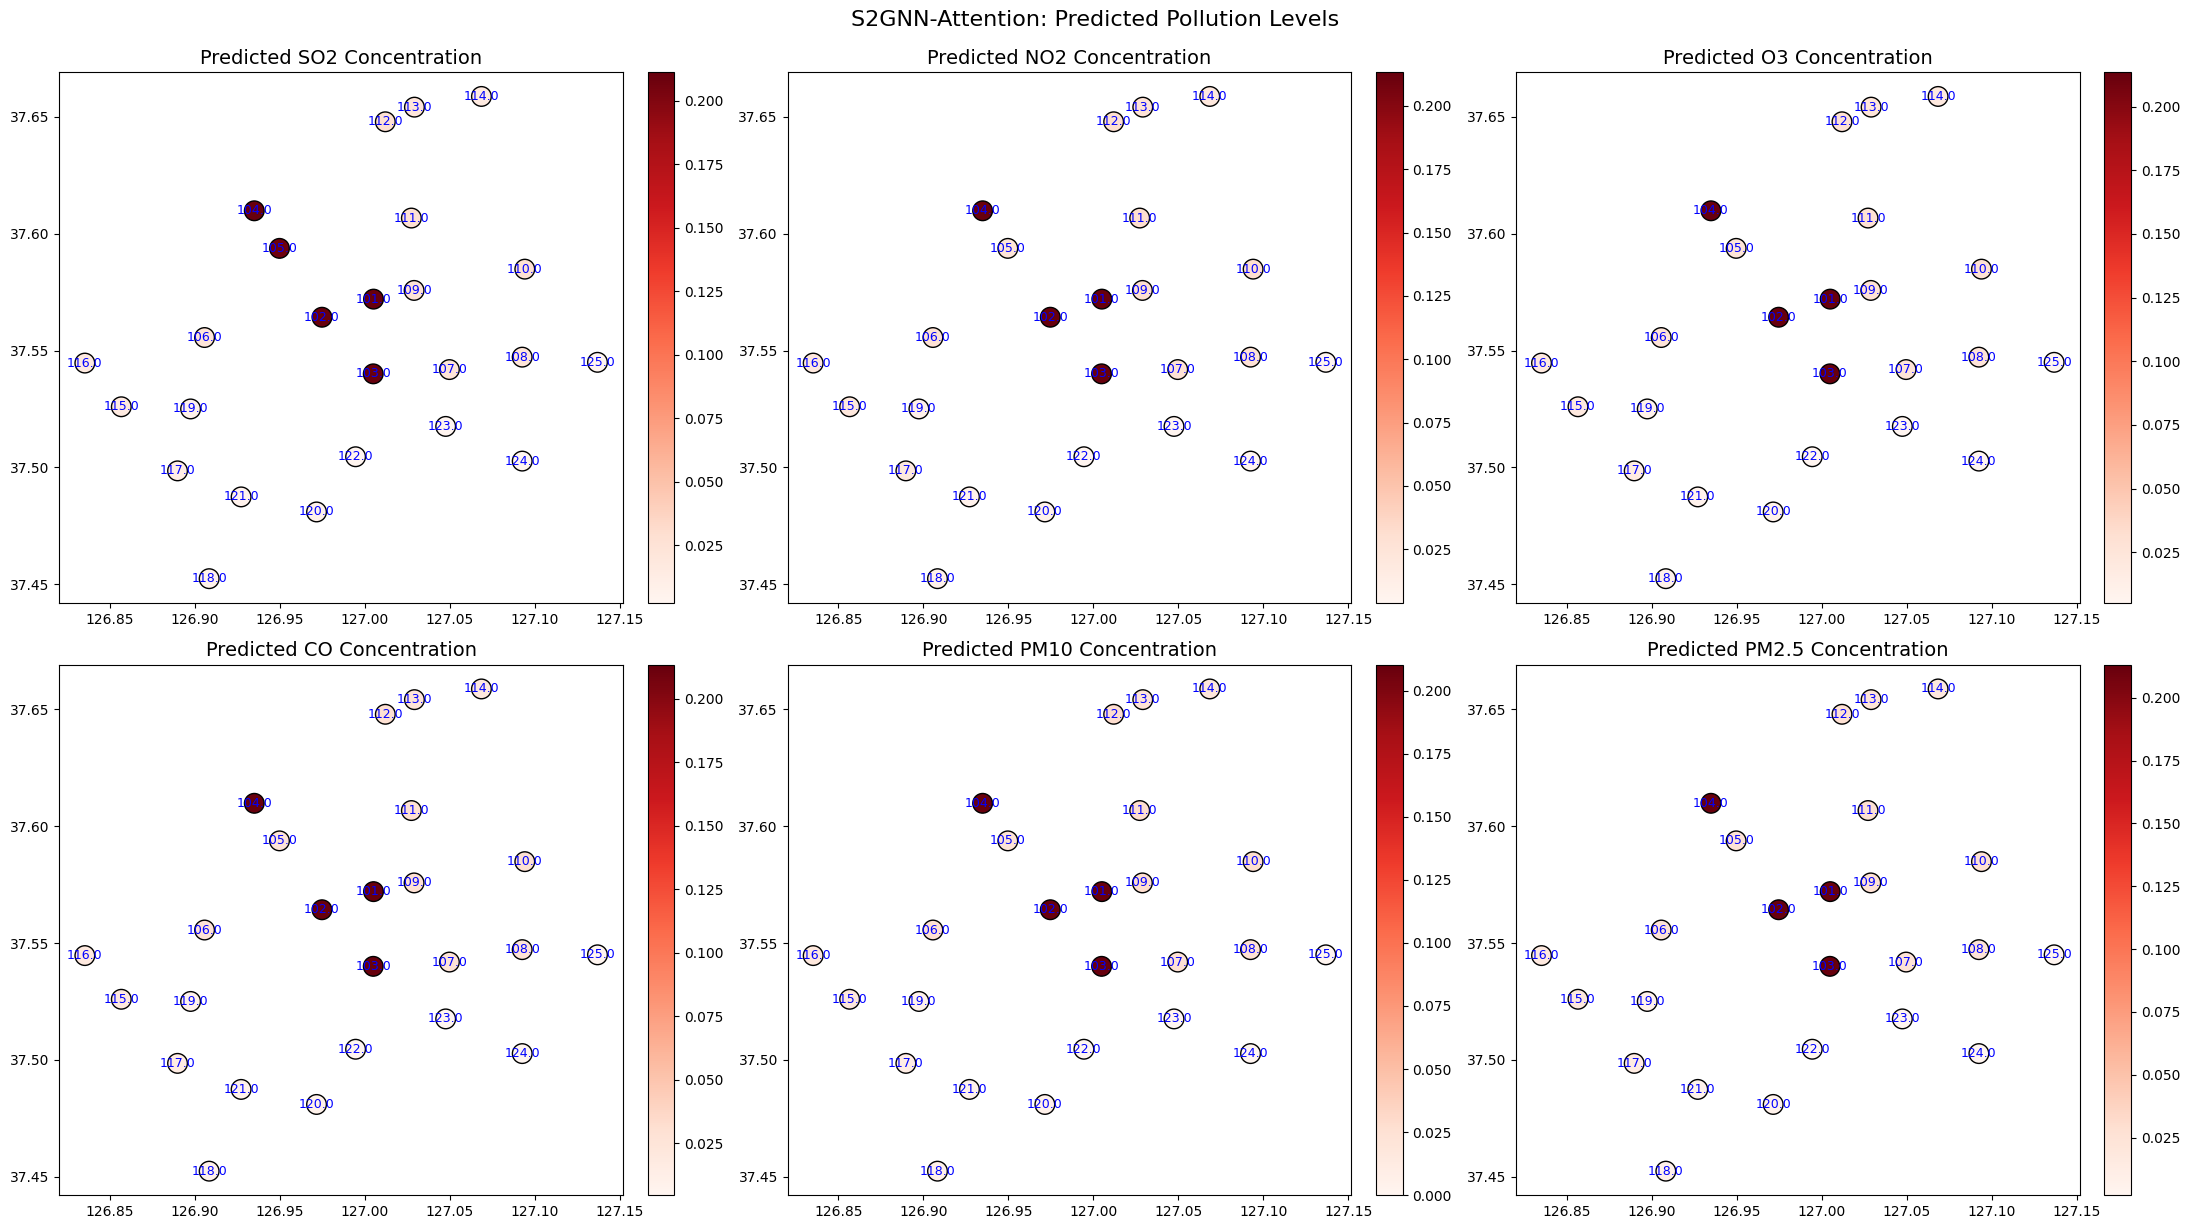

In [ ]:
latest_pred = preds[-1]
pollution_df = stations.copy()
for i, feat in enumerate(features):
    pollution_df[f"{feat}_pred"] = latest_pred[:, i]

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()
for i, feat in enumerate(features):
    ax = axes[i]
    sc = ax.scatter(pollution_df['Longitude'], pollution_df['Latitude'], c=pollution_df[f"{feat}_pred"], cmap='Reds', s=200, edgecolors='k')
    ax.set_title(f'Predicted {feat} Concentration', fontsize=14)
    for idx, row in pollution_df.iterrows():
        ax.text(row['Longitude'], row['Latitude'], str(row['Station code']), fontsize=9, ha='center', va='center', color='blue')
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle("S2GNN-Attention: Predicted Pollution Levels", fontsize=16, y=1.02)
plt.show()


# GCN-LSTM

**GCN-LSTM MODEL DEFINITION**

In [ ]:

class GCN_LSTM(nn.Module):
    def __init__(self, num_nodes, in_features, gcn_hidden, lstm_hidden, out_features):
        super(GCN_LSTM, self).__init__()
        self.gcn = GCNConv(in_features, gcn_hidden)
        self.lstm = nn.LSTM(gcn_hidden, lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, out_features)
        self.num_nodes = num_nodes
        self.gcn_hidden = gcn_hidden
    def forward(self, X, edge_index, edge_weight=None):
        B, T, N, F_in = X.size() # Renamed F to F_in to avoid conflict with the imported F
        gcn_out_seq = []
        for t in range(T):
            x_t = X[:, t, :, :].reshape(B * N, F_in)
            gcn_t = F.relu(self.gcn(x_t, edge_index, edge_weight))
            gcn_out_seq.append(gcn_t.reshape(B, N, -1))
        gcn_seq = torch.stack(gcn_out_seq, dim=1)
        lstm_in = gcn_seq.permute(0, 2, 1, 3).contiguous().view(B * N, T, self.gcn_hidden)
        lstm_out, _ = self.lstm(lstm_in)
        lstm_last = lstm_out[:, -1, :]
        out = self.fc(lstm_last)
        return out.view(B, N, -1)

**TRAINING AND EVALUATION**

In [ ]:
model = GCN_LSTM(num_nodes=A_tensor.size(0), in_features=len(features), gcn_hidden=32, lstm_hidden=64, out_features=len(features)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 50
batch_size = 64

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X, edge_index, edge_weight)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.8f}")

model.eval()
preds = []
with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_preds = model(batch_X_test, edge_index, edge_weight).cpu().numpy()
        preds.append(batch_preds)
preds = np.concatenate(preds, axis=0)

y_true_flat = y_test_tensor.cpu().numpy().flatten()
y_pred_flat = preds.flatten()
mae = mean_absolute_error(y_true_flat, y_pred_flat)
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, y_pred_flat)

print("\n--- GCN-LSTM Test Set Evaluation ---")
print(f"MAE: {mae:.8f}, MSE: {mse:.8f}, RMSE: {rmse:.8f}, R²: {r2:.8f}")

Epoch 1, Train Loss: 0.00052904
Epoch 2, Train Loss: 0.00051215
Epoch 3, Train Loss: 0.00046467
Epoch 4, Train Loss: 0.00028316
Epoch 5, Train Loss: 0.00019807
Epoch 6, Train Loss: 0.00020814
Epoch 7, Train Loss: 0.00016805
Epoch 8, Train Loss: 0.00028909
Epoch 9, Train Loss: 0.00015314
Epoch 10, Train Loss: 0.00018960
Epoch 11, Train Loss: 0.00011664
Epoch 12, Train Loss: 0.00010557
Epoch 13, Train Loss: 0.00069370
Epoch 14, Train Loss: 0.00006211
Epoch 15, Train Loss: 0.00004146
Epoch 16, Train Loss: 0.00005590
Epoch 17, Train Loss: 0.00003521
Epoch 18, Train Loss: 0.00007466
Epoch 19, Train Loss: 0.00004879
Epoch 20, Train Loss: 0.00014708
Epoch 21, Train Loss: 0.00008224
Epoch 22, Train Loss: 0.00002857
Epoch 23, Train Loss: 0.00005055
Epoch 24, Train Loss: 0.00002302
Epoch 25, Train Loss: 0.00006315
Epoch 26, Train Loss: 0.00002925
Epoch 27, Train Loss: 0.00003646
Epoch 28, Train Loss: 0.00012882
Epoch 29, Train Loss: 0.00012327
Epoch 30, Train Loss: 0.00003762
Epoch 31, Train Los

**VISUALIZATION**

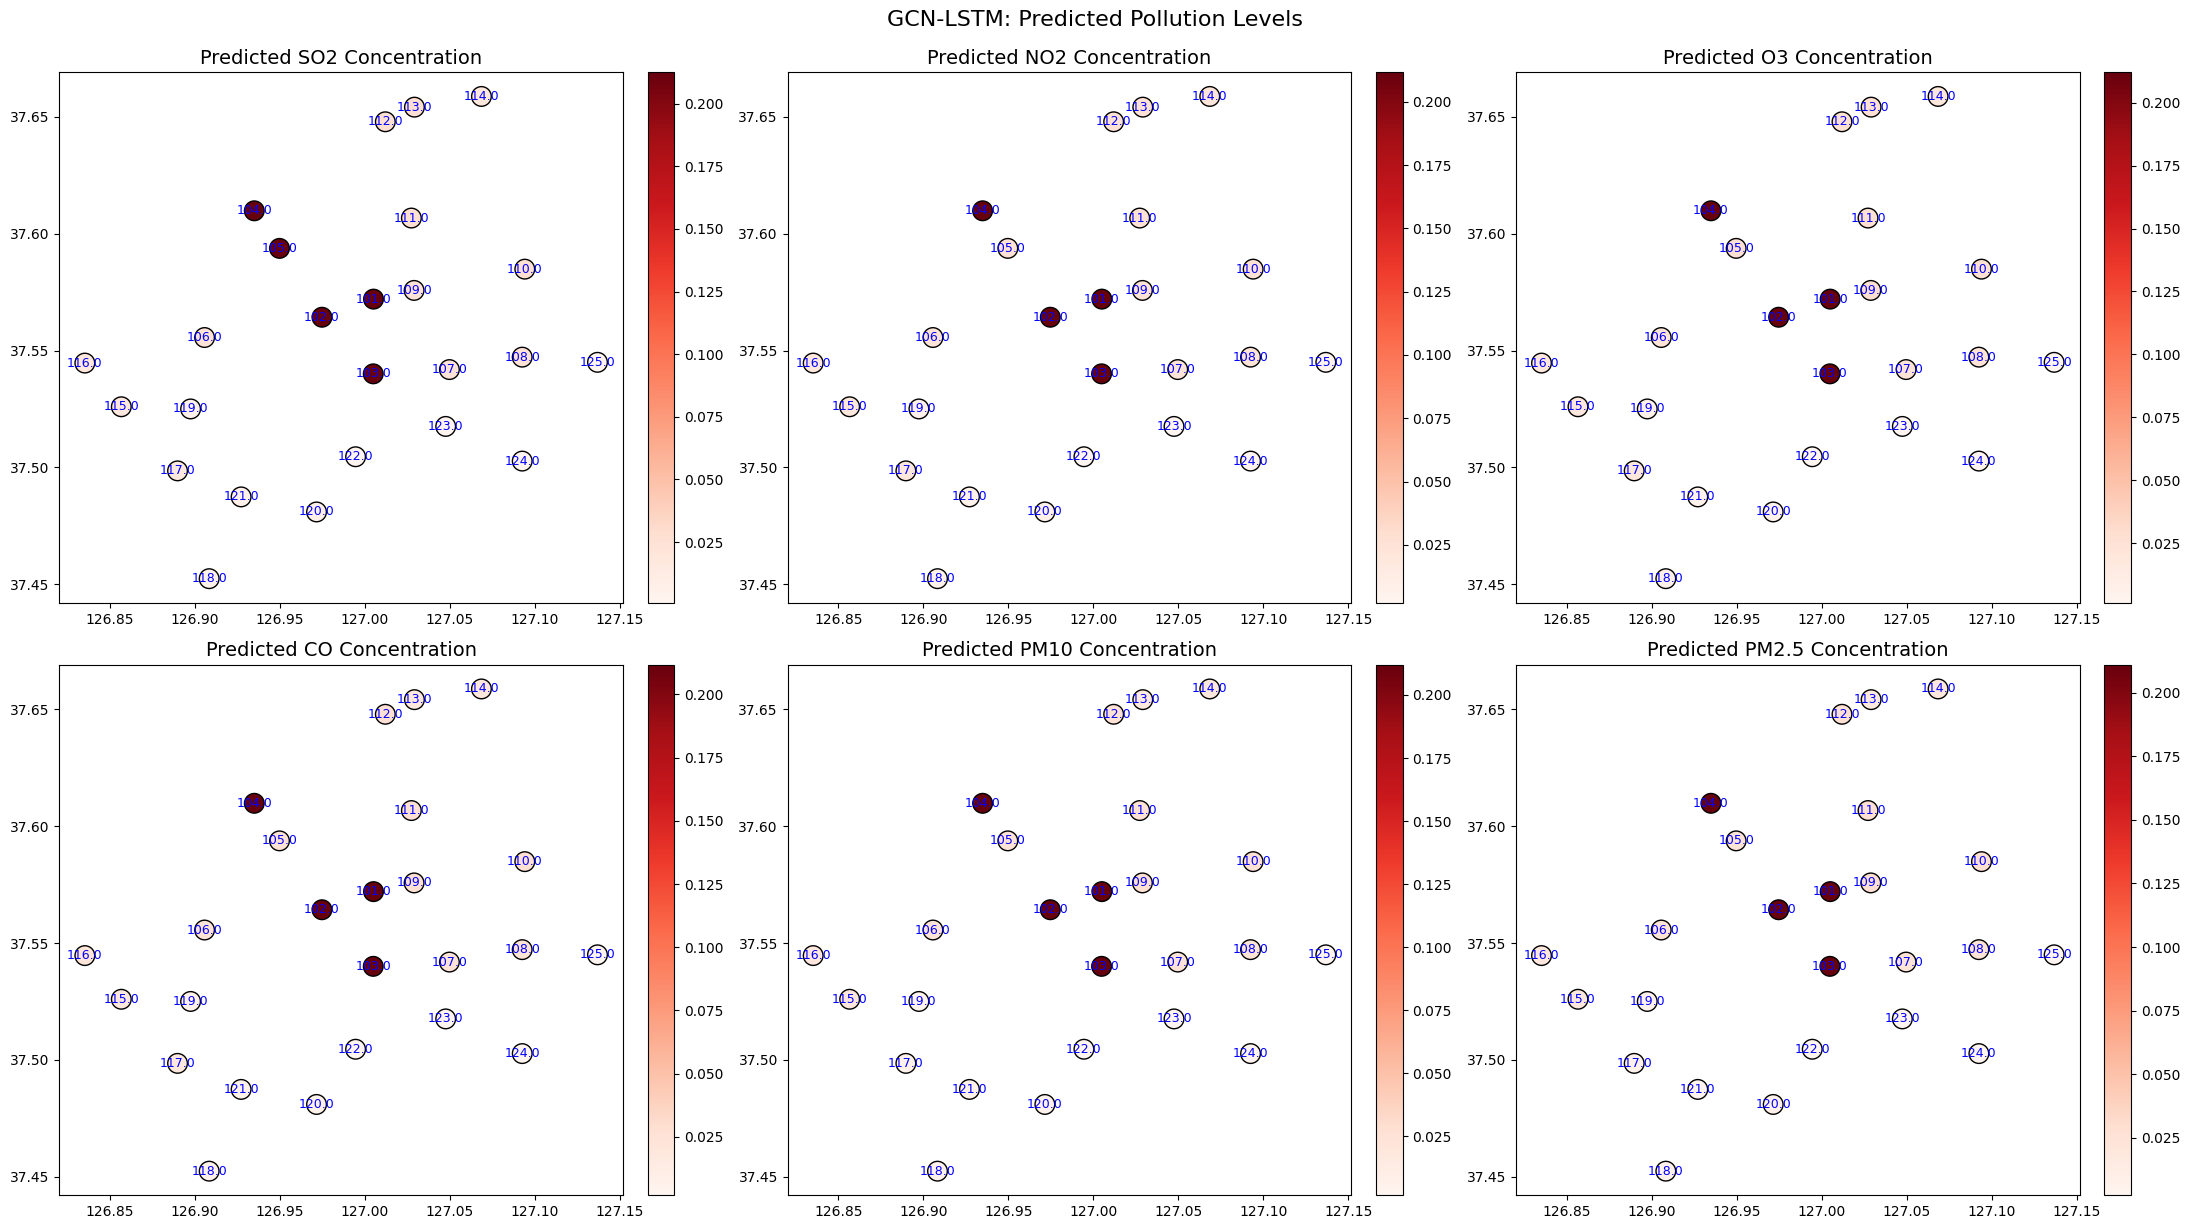

In [ ]:
latest_pred = preds[-1]
pollution_df = stations.copy()
for i, feat in enumerate(features):
    pollution_df[f"{feat}_pred"] = latest_pred[:, i]

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()
for i, feat in enumerate(features):
    ax = axes[i]
    sc = ax.scatter(pollution_df['Longitude'], pollution_df['Latitude'], c=pollution_df[f"{feat}_pred"], cmap='Reds', s=200, edgecolors='k')
    ax.set_title(f'Predicted {feat} Concentration', fontsize=14)
    for idx, row in pollution_df.iterrows():
        ax.text(row['Longitude'], row['Latitude'], str(row['Station code']), fontsize=9, ha='center', va='center', color='blue')
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle("GCN-LSTM: Predicted Pollution Levels", fontsize=16, y=1.02)
plt.show()

#AIST Gat ltsm

**Model Defination**

In [ ]:
class AIST_GAT_LSTM(nn.Module):
    def __init__(self, in_features, gat_hidden, lstm_hidden, out_features, heads):
        super(AIST_GAT_LSTM, self).__init__()
        self.gat = GATConv(in_features, gat_hidden, heads=heads)
        self.lstm = nn.LSTM(gat_hidden * heads, lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, out_features)

    def forward(self, x, edge_index, edge_weight=None):
        B, T, N, C = x.size()
        gat_out_seq = []
        for t in range(T):
            # Apply GAT to each time step's snapshot
            x_t = x[:, t, :, :].reshape(B * N, C)
            gat_t = F.elu(self.gat(x_t, edge_index))
            gat_out_seq.append(gat_t.reshape(B, N, -1))

        gat_seq = torch.stack(gat_out_seq, dim=1)  # Shape: (B, T, N, gat_hidden * heads)

        # Reshape for LSTM: treat each node's time series independently
        lstm_in = gat_seq.permute(0, 2, 1, 3).contiguous().view(B * N, T, -1)
        lstm_out, _ = self.lstm(lstm_in)

        # We only need the last output of the LSTM
        lstm_last = lstm_out[:, -1, :]
        out = self.fc(lstm_last)
        return out.view(B, N, -1)

**TRAINING AND EVALUATION**

In [ ]:
model = AIST_GAT_LSTM(in_features=len(features), gat_hidden=8, lstm_hidden=64, out_features=len(features), heads=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 50
batch_size = 64

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X, edge_index, edge_weight)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.8f}")

model.eval()
preds = []
with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_preds = model(batch_X_test, edge_index, edge_weight).cpu().numpy()
        preds.append(batch_preds)
preds = np.concatenate(preds, axis=0)

y_true_flat = y_test_tensor.cpu().numpy().flatten()
y_pred_flat = preds.flatten()
mae = mean_absolute_error(y_true_flat, y_pred_flat)
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, y_pred_flat)

print("\n--- AIST (GAT+LSTM) Test Set Evaluation ---")
print(f"MAE: {mae:.8f}, MSE: {mse:.8f}, RMSE: {rmse:.8f}, R²: {r2:.8f}")

Epoch 1, Train Loss: 0.00144101
Epoch 2, Train Loss: 0.00106824
Epoch 3, Train Loss: 0.00107913
Epoch 4, Train Loss: 0.00102548
Epoch 5, Train Loss: 0.00107075
Epoch 6, Train Loss: 0.00108015
Epoch 7, Train Loss: 0.00104344
Epoch 8, Train Loss: 0.00103772
Epoch 9, Train Loss: 0.00104598
Epoch 10, Train Loss: 0.00102193
Epoch 11, Train Loss: 0.00107464
Epoch 12, Train Loss: 0.00104549
Epoch 13, Train Loss: 0.00107565
Epoch 14, Train Loss: 0.00107719
Epoch 15, Train Loss: 0.00106138
Epoch 16, Train Loss: 0.00105744
Epoch 17, Train Loss: 0.00102792
Epoch 18, Train Loss: 0.00105904
Epoch 19, Train Loss: 0.00107095
Epoch 20, Train Loss: 0.00103005
Epoch 21, Train Loss: 0.00121122
Epoch 22, Train Loss: 0.00102813
Epoch 23, Train Loss: 0.00108567
Epoch 24, Train Loss: 0.00102312
Epoch 25, Train Loss: 0.00143787
Epoch 26, Train Loss: 0.00108602
Epoch 27, Train Loss: 0.00102002
Epoch 28, Train Loss: 0.00149896
Epoch 29, Train Loss: 0.00106780
Epoch 30, Train Loss: 0.00107131
Epoch 31, Train Los

**VISUALIZATION**

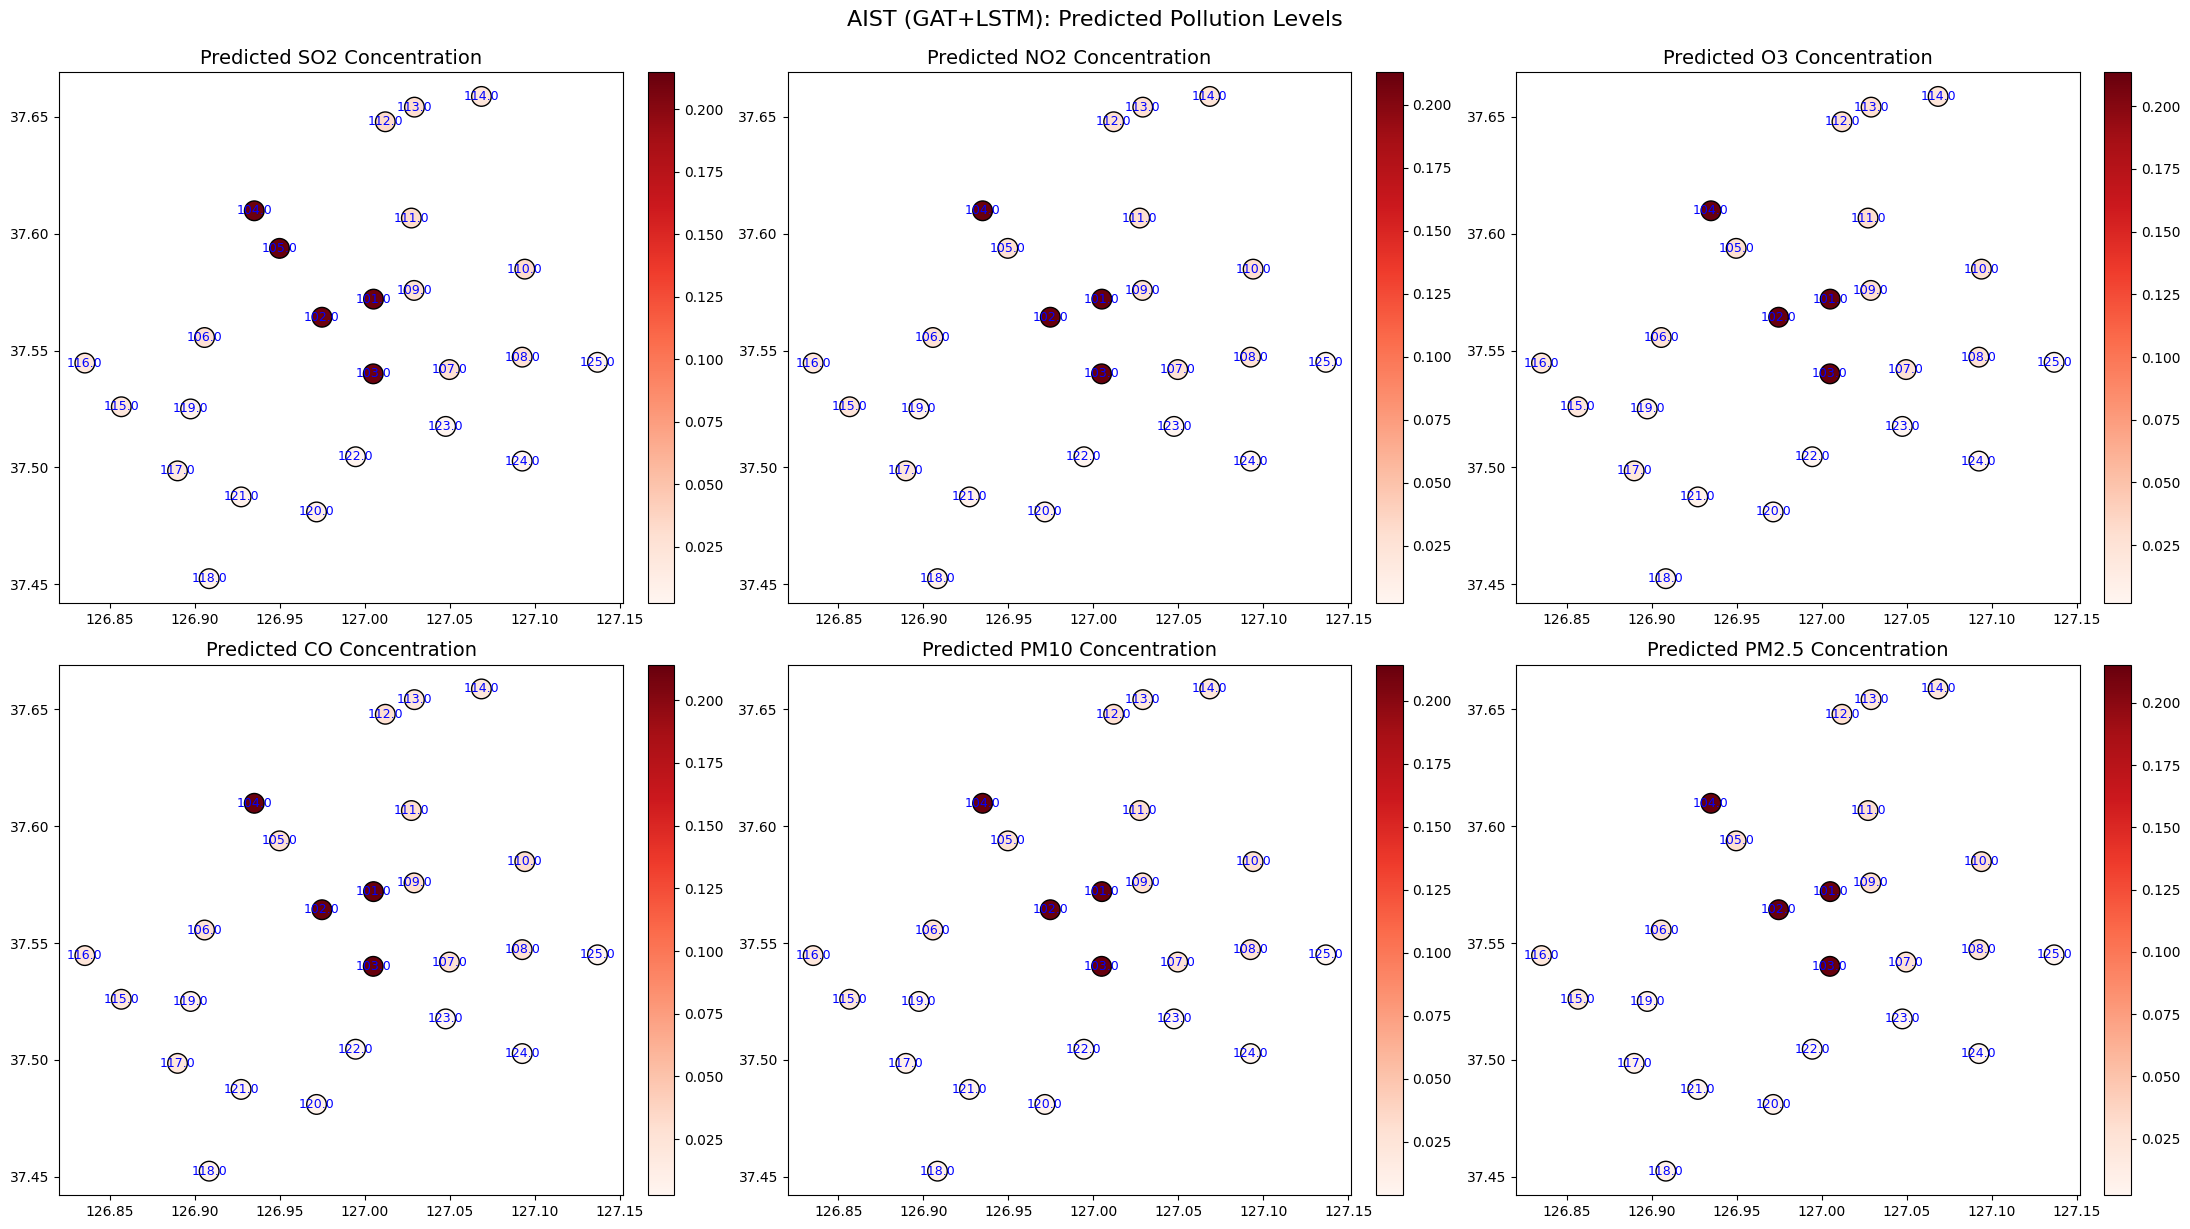

In [ ]:
latest_pred = preds[-1]
pollution_df = stations.copy()
for i, feat in enumerate(features):
    pollution_df[f"{feat}_pred"] = latest_pred[:, i]

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()
for i, feat in enumerate(features):
    ax = axes[i]
    sc = ax.scatter(pollution_df['Longitude'], pollution_df['Latitude'], c=pollution_df[f"{feat}_pred"], cmap='Reds', s=200, edgecolors='k')
    ax.set_title(f'Predicted {feat} Concentration', fontsize=14)
    for idx, row in pollution_df.iterrows():
        ax.text(row['Longitude'], row['Latitude'], str(row['Station code']), fontsize=9, ha='center', va='center', color='blue')
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle("AIST (GAT+LSTM): Predicted Pollution Levels", fontsize=16, y=1.02)
plt.show()


# SpectralGCN-Attention-LSTM 3rd order

**Model Defination**

In [ ]:
class SpectralGCN_Attention_LSTM(nn.Module):
    def __init__(self, in_features, gcn_hidden, gat_hidden, lstm_hidden, out_features, K, heads):
        super(SpectralGCN_Attention_LSTM, self).__init__()
        self.gcn = ChebConv(in_features, gcn_hidden, K=K)
        self.gat = GATConv(gcn_hidden, gat_hidden, heads=heads)
        self.lstm = nn.LSTM(gat_hidden * heads, lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, out_features)

    def forward(self, x, edge_index, edge_weight=None):
        B, T, N, C = x.size()
        final_out_seq = []
        for t in range(T):
            x_t = x[:, t, :, :].reshape(B * N, C)
            # 1. Apply Spectral GCN (ChebConv)
            gcn_t = F.relu(self.gcn(x_t, edge_index))
            # 2. Apply Graph Attention to the result
            gat_t = F.elu(self.gat(gcn_t, edge_index))
            final_out_seq.append(gat_t.reshape(B, N, -1))

        final_seq = torch.stack(final_out_seq, dim=1)

        # Reshape for LSTM
        lstm_in = final_seq.permute(0, 2, 1, 3).contiguous().view(B * N, T, -1)
        lstm_out, _ = self.lstm(lstm_in)

        # Get last output and pass to final layer
        lstm_last = lstm_out[:, -1, :]
        out = self.fc(lstm_last)
        return out.view(B, N, -1)


**TRAINING AND EVALUATION**

In [ ]:
model = SpectralGCN_Attention_LSTM(in_features=len(features), gcn_hidden=16, gat_hidden=8, lstm_hidden=64, out_features=len(features), K=3, heads=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 50
batch_size = 64

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X, edge_index, edge_weight)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.8f}")

model.eval()
preds = []
with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_preds = model(batch_X_test, edge_index, edge_weight).cpu().numpy()
        preds.append(batch_preds)
preds = np.concatenate(preds, axis=0)

y_true_flat = y_test_tensor.cpu().numpy().flatten()
y_pred_flat = preds.flatten()
mae = mean_absolute_error(y_true_flat, y_pred_flat)
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, y_pred_flat)

print("\n--- SpectralGCN-Attention-LSTM Test Set Evaluation ---")
print(f"MAE: {mae:.8f}, MSE: {mse:.8f}, RMSE: {rmse:.8f}, R²: {r2:.8f}")

Epoch 1, Train Loss: 0.00107289
Epoch 2, Train Loss: 0.00007070
Epoch 3, Train Loss: 0.00003937
Epoch 4, Train Loss: 0.00003437
Epoch 5, Train Loss: 0.00003903
Epoch 6, Train Loss: 0.00004443
Epoch 7, Train Loss: 0.00005155
Epoch 8, Train Loss: 0.00000883
Epoch 9, Train Loss: 0.00000556
Epoch 10, Train Loss: 0.00001615
Epoch 11, Train Loss: 0.00000642
Epoch 12, Train Loss: 0.00000457
Epoch 13, Train Loss: 0.00003292
Epoch 14, Train Loss: 0.00003642
Epoch 15, Train Loss: 0.00001729
Epoch 16, Train Loss: 0.00006462
Epoch 17, Train Loss: 0.00011498
Epoch 18, Train Loss: 0.00012288
Epoch 19, Train Loss: 0.00000704
Epoch 20, Train Loss: 0.00000634
Epoch 21, Train Loss: 0.00001565
Epoch 22, Train Loss: 0.00003570
Epoch 23, Train Loss: 0.00000357
Epoch 24, Train Loss: 0.00000361
Epoch 25, Train Loss: 0.00001133
Epoch 26, Train Loss: 0.00000367
Epoch 27, Train Loss: 0.00001592
Epoch 28, Train Loss: 0.00007225
Epoch 29, Train Loss: 0.00005243
Epoch 30, Train Loss: 0.00000951
Epoch 31, Train Los

**VISUALIZATION**

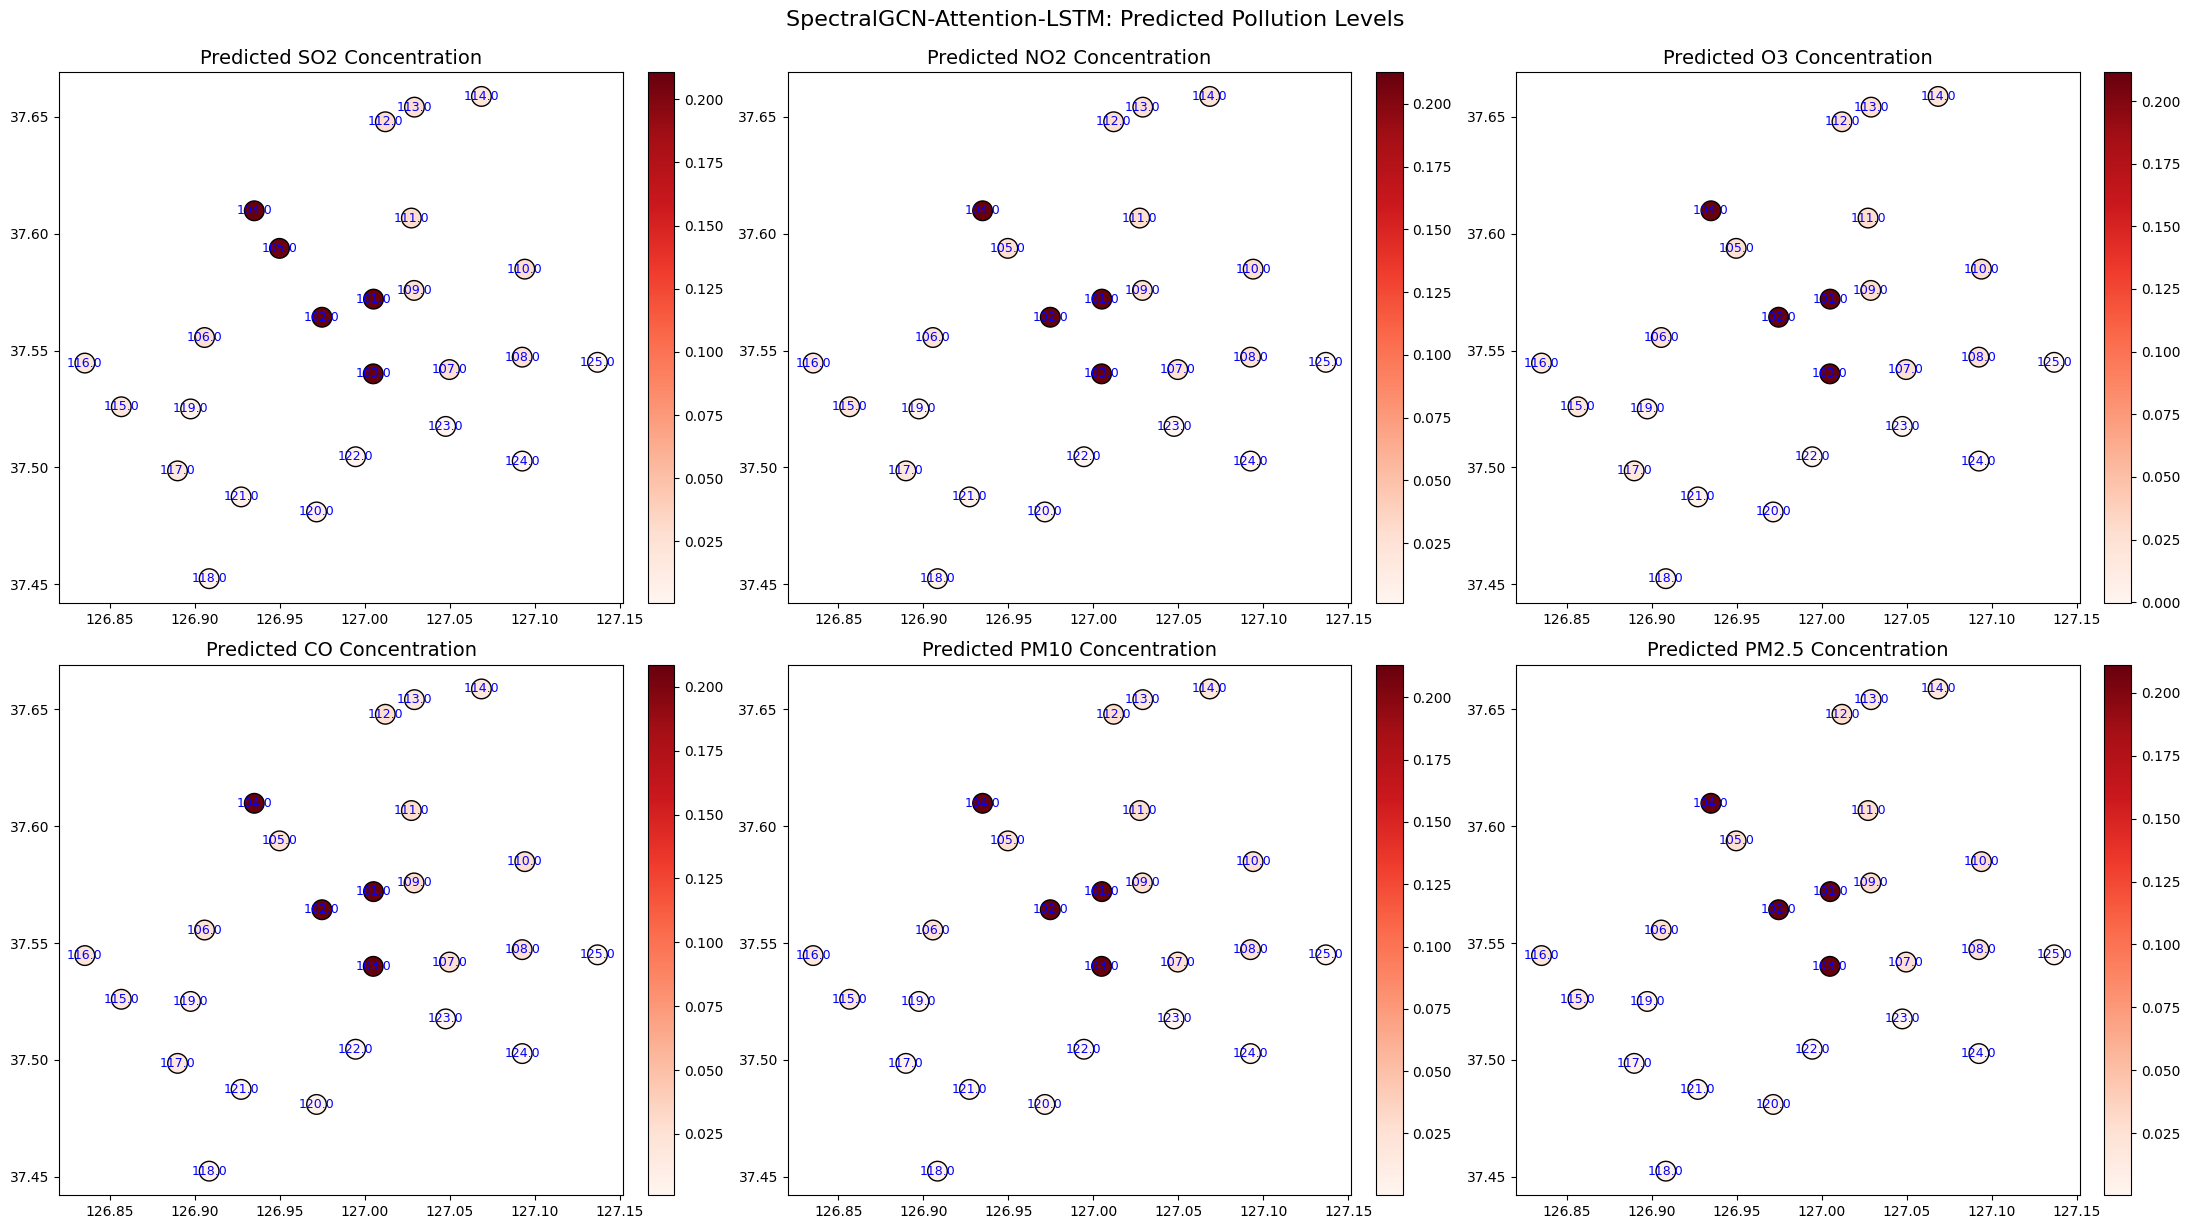

In [ ]:
latest_pred = preds[-1]
pollution_df = stations.copy()
for i, feat in enumerate(features):
    pollution_df[f"{feat}_pred"] = latest_pred[:, i]

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()
for i, feat in enumerate(features):
    ax = axes[i]
    sc = ax.scatter(pollution_df['Longitude'], pollution_df['Latitude'], c=pollution_df[f"{feat}_pred"], cmap='Reds', s=200, edgecolors='k')
    ax.set_title(f'Predicted {feat} Concentration', fontsize=14)
    for idx, row in pollution_df.iterrows():
        ax.text(row['Longitude'], row['Latitude'], str(row['Station code']), fontsize=9, ha='center', va='center', color='blue')
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle("SpectralGCN-Attention-LSTM: Predicted Pollution Levels", fontsize=16, y=1.02)
plt.show()


# SpectralGCN-Attention-LSTM 2rd order

In [ ]:
model = SpectralGCN_Attention_LSTM(in_features=len(features), gcn_hidden=16, gat_hidden=8, lstm_hidden=64, out_features=len(features), K=2, heads=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 50
batch_size = 64

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X, edge_index, edge_weight)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.8f}")

model.eval()
preds = []
with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_preds = model(batch_X_test, edge_index, edge_weight).cpu().numpy()
        preds.append(batch_preds)
preds = np.concatenate(preds, axis=0)

y_true_flat = y_test_tensor.cpu().numpy().flatten()
y_pred_flat = preds.flatten()
mae = mean_absolute_error(y_true_flat, y_pred_flat)
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, y_pred_flat)

print("\n--- SpectralGCN-Attention-LSTM Test Set Evaluation ---")
print(f"MAE: {mae:.8f}, MSE: {mse:.8f}, RMSE: {rmse:.8f}, R²: {r2:.8f}")

Epoch 1, Train Loss: 0.00106203
Epoch 2, Train Loss: 0.00105187
Epoch 3, Train Loss: 0.00024071
Epoch 4, Train Loss: 0.00009779
Epoch 5, Train Loss: 0.00003882
Epoch 6, Train Loss: 0.00005630
Epoch 7, Train Loss: 0.00002350
Epoch 8, Train Loss: 0.00002182
Epoch 9, Train Loss: 0.00004527
Epoch 10, Train Loss: 0.00003262
Epoch 11, Train Loss: 0.00006530
Epoch 12, Train Loss: 0.00001504
Epoch 13, Train Loss: 0.00009916
Epoch 14, Train Loss: 0.00000626
Epoch 15, Train Loss: 0.00000315
Epoch 16, Train Loss: 0.00000286
Epoch 17, Train Loss: 0.00001929
Epoch 18, Train Loss: 0.00000691
Epoch 19, Train Loss: 0.00040523
Epoch 20, Train Loss: 0.00000678
Epoch 21, Train Loss: 0.00000587
Epoch 22, Train Loss: 0.00000344
Epoch 23, Train Loss: 0.00000475
Epoch 24, Train Loss: 0.00000369
Epoch 25, Train Loss: 0.00040188
Epoch 26, Train Loss: 0.00000358
Epoch 27, Train Loss: 0.00002731
Epoch 28, Train Loss: 0.00000317
Epoch 29, Train Loss: 0.00000754
Epoch 30, Train Loss: 0.00000400
Epoch 31, Train Los

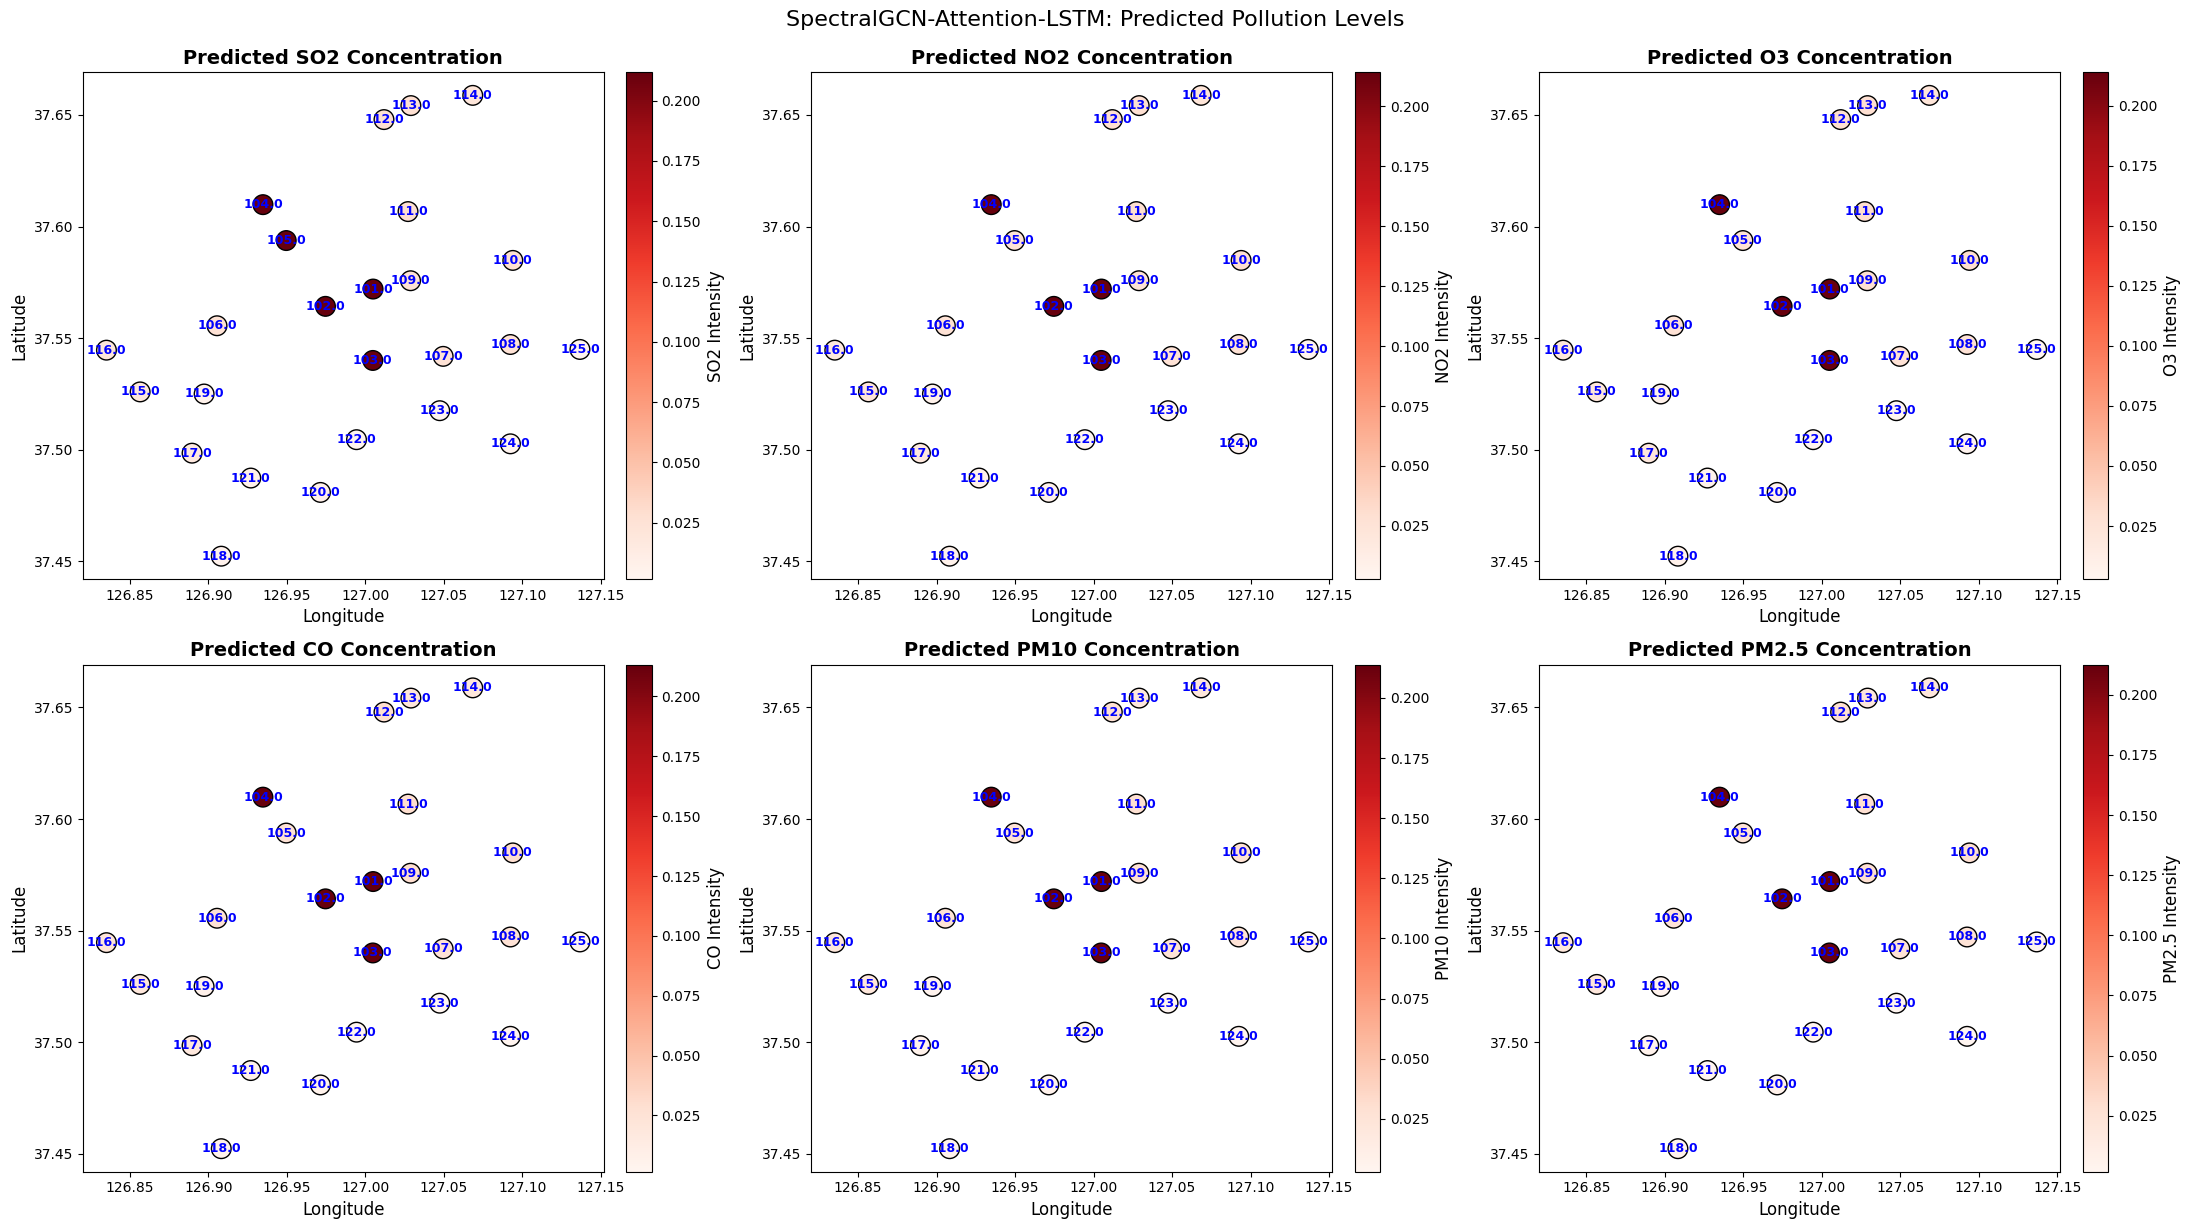

In [ ]:
latest_pred = preds[-1]
pollution_df = stations.copy()
for i, feat in enumerate(features):
    pollution_df[f"{feat}_pred"] = latest_pred[:, i]

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()

for i, feat in enumerate(features):
    ax = axes[i]

    # Scatter Plot
    sc = ax.scatter(pollution_df['Longitude'], pollution_df['Latitude'],
                    c=pollution_df[f"{feat}_pred"], cmap='Reds', s=200, edgecolors='k')

    # --- ADDED LABELS ---
    ax.set_title(f'Predicted {feat} Concentration', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=12)  # X-axis Label
    ax.set_ylabel('Latitude', fontsize=12)   # Y-axis Label

    # Station Text
    for idx, row in pollution_df.iterrows():
        ax.text(row['Longitude'], row['Latitude'], str(row['Station code']),
                fontsize=9, ha='center', va='center', color='blue', fontweight='bold')

    # Colorbar with Label
    cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(f'{feat} Intensity', fontsize=12) # Colorbar Label

plt.tight_layout()
plt.suptitle("SpectralGCN-Attention-LSTM: Predicted Pollution Levels", fontsize=16, y=1.02)
plt.show()

# Gat - sablstm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm

In [ ]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, in_features, d_k):
        super(SelfAttentionBlock, self).__init__()
        self.query = nn.Linear(in_features, d_k)
        self.key = nn.Linear(in_features, d_k)
        self.value = nn.Linear(in_features, in_features)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        attn_weights = F.softmax(torch.matmul(q, k.transpose(-2, -1)) / (k.size(-1) ** 0.5), dim=-1)
        output = torch.matmul(attn_weights, v)
        return output

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, heads=1, dropout=0.6):
        super(GATLayer, self).__init__()
        self.gatconv = GATConv(in_features, out_features, heads=heads, dropout=dropout, add_self_loops=False)

    def forward(self, x, edge_index, edge_weight=None):
        return F.relu(self.gatconv(x, edge_index, edge_attr=edge_weight))

class GAT_SAB_LSTM(nn.Module):
    def __init__(self, num_nodes, in_features, gat_hidden, lstm_hidden, out_features, heads=1, dropout=0.6, d_k=64):
        super(GAT_SAB_LSTM, self).__init__()
        self.num_nodes = num_nodes
        self.gat = GATLayer(in_features, gat_hidden, heads=heads, dropout=dropout)
        self.sab = SelfAttentionBlock(gat_hidden * heads, d_k)
        self.lstm = nn.LSTM(gat_hidden * heads, lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, out_features)

    # This is the corrected forward method
    def forward(self, X, edge_index, edge_weight=None):
        B, T, N, F = X.size()

        gat_out_seq = []
        for t in range(T):
            x_t = X[:, t, :, :].reshape(B * N, F)

            edge_index_batch = torch.cat([edge_index + i * N for i in range(B)], dim=1)
            edge_weight_batch = torch.cat([edge_weight for i in range(B)]) if edge_weight is not None else None

            gat_t = self.gat(x_t, edge_index_batch, edge_weight_batch)
            gat_t = gat_t.reshape(B, N, -1)
            gat_out_seq.append(gat_t)

        gat_seq = torch.stack(gat_out_seq, dim=1)

        sab_in = gat_seq.reshape(B * T, N, -1)
        sab_out = self.sab(sab_in)
        sab_out = sab_out.reshape(B, T, N, -1)

        lstm_in = sab_out.permute(0, 2, 1, 3).contiguous().reshape(B * N, T, -1)

        lstm_out, _ = self.lstm(lstm_in)
        lstm_last = lstm_out[:, -1, :]

        out = self.fc(lstm_last)
        return out.reshape(B, N, -1)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


gat_sab_lstm_model = GAT_SAB_LSTM(
    num_nodes=A_tensor.size(0),
    in_features=len(features),
    gat_hidden=32,
    lstm_hidden=64,
    out_features=len(features),
    heads=2,
    dropout=0.5,
    d_k=64
).to(device)


optimizer = torch.optim.Adam(gat_sab_lstm_model.parameters(), lr=0.001)
criterion = nn.MSELoss()
batch_size = 64
epochs = 50

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)


print("Starting GAT-SAB-LSTM Model Training...")

gat_sab_lstm_model.train()

for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = gat_sab_lstm_model(batch_X, edge_index.to(device), edge_weight.to(device))
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.8f}')

print("Training finished.")


print("\nStarting GAT-SAB-LSTM Model Evaluation...")
gat_sab_lstm_model.eval()
preds = []

with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_X_test = batch_X_test.to(device)
        batch_preds = gat_sab_lstm_model(batch_X_test, edge_index.to(device), edge_weight.to(device)).cpu().numpy()
        preds.append(batch_preds)

preds = np.concatenate(preds, axis=0)

y_true_flat = y_test_tensor.cpu().numpy().flatten()
y_pred_flat = preds.flatten()

mae = mean_absolute_error(y_true_flat, y_pred_flat)
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, y_pred_flat)

print("\n--- GAT-SAB-LSTM ---")
print(f"MAE: {mae:.8f}, MSE: {mse:.8f}, RMSE: {rmse:.8f}, R²: {r2:.8f}")

Starting GAT-SAB-LSTM Model Training...
Epoch [1/50], Loss: 0.00525141
Epoch [2/50], Loss: 0.00521842
Epoch [3/50], Loss: 0.00528759
Epoch [4/50], Loss: 0.00039881
Epoch [5/50], Loss: 0.00016223
Epoch [6/50], Loss: 0.00112124
Epoch [7/50], Loss: 0.00014529
Epoch [8/50], Loss: 0.00031194
Epoch [9/50], Loss: 0.00010321
Epoch [10/50], Loss: 0.00014345
Epoch [11/50], Loss: 0.00002199
Epoch [12/50], Loss: 0.00005082
Epoch [13/50], Loss: 0.00002442
Epoch [14/50], Loss: 0.00005333
Epoch [15/50], Loss: 0.00004054
Epoch [16/50], Loss: 0.00009102
Epoch [17/50], Loss: 0.00002309
Epoch [18/50], Loss: 0.00002181
Epoch [19/50], Loss: 0.00050790
Epoch [20/50], Loss: 0.00003338
Epoch [21/50], Loss: 0.00001945
Epoch [22/50], Loss: 0.00002387
Epoch [23/50], Loss: 0.00001978
Epoch [24/50], Loss: 0.00010755
Epoch [25/50], Loss: 0.00001128
Epoch [26/50], Loss: 0.00017085
Epoch [27/50], Loss: 0.00007666
Epoch [28/50], Loss: 0.00005058
Epoch [29/50], Loss: 0.00007946
Epoch [30/50], Loss: 0.00001892
Epoch [31

In [ ]:
!pip install xlstm
!pip install mlstm_kernels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.7 MB/s eta 0:00:00


In [ ]:
from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
)
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F


class S2GNNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(S2GNNLayer, self).__init__()
        self.conv = GCNConv(in_features, out_features)

    def forward(self, X, edge_index, edge_weight=None):
        return F.relu(self.conv(X, edge_index, edge_weight))

class S2GNN_xLSTM(nn.Module):

    def __init__(self, in_features, gnn_hidden_features, xlstm_config, out_features):
        super(S2GNN_xLSTM, self).__init__()

        self.s2gnn = S2GNNLayer(in_features, gnn_hidden_features)
        self.xlstm_stack = xLSTMBlockStack(xlstm_config)


        xlstm_out_features = xlstm_config.slstm_block.slstm.hidden_size
        self.fc = nn.Linear(xlstm_out_features, out_features)

    def forward(self, X, edge_index, edge_weight=None):
        B, T, N, F_in = X.size()


        gnn_out_sequence = []
        for t in range(T):
            x_t = X[:, t, :, :].reshape(B * N, F_in)
            edge_index_batch = torch.cat([edge_index + i * N for i in range(B)], dim=1)
            edge_weight_batch = edge_weight.repeat(B) if edge_weight is not None else None

            gnn_t = self.s2gnn(x_t, edge_index_batch, edge_weight_batch)
            gnn_out_sequence.append(gnn_t.reshape(B, N, -1))

        gnn_out_sequence = torch.stack(gnn_out_sequence, dim=1)

        xlstm_in = gnn_out_sequence.permute(0, 2, 1, 3).contiguous().view(B * N, T, -1)
        xlstm_out = self.xlstm_stack(xlstm_in)


        last_time_step_out = xlstm_out[:, -1, :]
        output = self.fc(last_time_step_out)

        return output.view(B, N, -1)

In [ ]:

xlstm_config = xLSTMBlockStackConfig(
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            hidden_size=128,
            num_heads=8,
        )
    ),
    num_blocks=2,
)

model = S2GNN_xLSTM(
    in_features=len(features),
    gnn_hidden_features=128,
    xlstm_config=xlstm_config,
    out_features=len(features)
).to(device)


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_

W1024 05:14:33.163000 1422 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1024 05:14:33.163000 1422 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.
/usr/local/lib/python3.12/dist-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/usr/local/lib/python3.12/dist-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(" Model Initialized Successfully!")



train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

print(" DataLoaders Created.")




print(" Starting Model Training ")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)


        edge_index_data = edge_index.to(device)
        edge_weight_data = edge_weight.to(device) if edge_weight is not None else None

        optimizer.zero_grad()

        y_pred = model(batch_X, edge_index_data, edge_weight_data)
        loss = criterion(y_pred, batch_y)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.8f}")

print("--- Training Complete ---")


print("\n--- Evaluating Model on Test Set ---")
model.eval()
preds = []
with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_X_test = batch_X_test.to(device)

        edge_index_data = edge_index.to(device)
        edge_weight_data = edge_weight.to(device) if edge_weight is not None else None

        batch_preds = model(batch_X_test, edge_index_data, edge_weight_data).cpu().numpy()
        preds.append(batch_preds)

preds = np.concatenate(preds, axis=0)

y_pred_flat = preds.flatten()

mae = mean_absolute_error(y_true_flat, y_pred_flat)
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, y_pred_flat)

print("\n--- S2GNN-xLSTM")
print(f"MAE: {mae:.8f}, MSE: {mse:.8f}, RMSE: {rmse:.8f}, R²: {r2:.8f}")

✅ Model Initialized Successfully!
✅ DataLoaders Created.

--- Starting Model Training ---
Epoch 1/50, Train Loss: 0.00452856
Epoch 2/50, Train Loss: 0.00022671
Epoch 3/50, Train Loss: 0.00021090
Epoch 4/50, Train Loss: 0.00018656
Epoch 5/50, Train Loss: 0.00018397
Epoch 6/50, Train Loss: 0.00017660
Epoch 7/50, Train Loss: 0.00013228
Epoch 8/50, Train Loss: 0.00012809
Epoch 9/50, Train Loss: 0.00012478
Epoch 10/50, Train Loss: 0.00012204
Epoch 11/50, Train Loss: 0.00012449
Epoch 12/50, Train Loss: 0.00012123
Epoch 13/50, Train Loss: 0.00011712
Epoch 14/50, Train Loss: 0.00011429
Epoch 15/50, Train Loss: 0.00011317
Epoch 16/50, Train Loss: 0.00010561
Epoch 17/50, Train Loss: 0.00010916
Epoch 18/50, Train Loss: 0.00010324
Epoch 19/50, Train Loss: 0.00010091
Epoch 20/50, Train Loss: 0.00010036
Epoch 21/50, Train Loss: 0.00009905
Epoch 22/50, Train Loss: 0.00009855
Epoch 23/50, Train Loss: 0.00009851
Epoch 24/50, Train Loss: 0.00009498
Epoch 25/50, Train Loss: 0.00009347
Epoch 26/50, Train 

# S2gnn - Bilstm


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree


class S2GNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(S2GNN, self).__init__(aggr='add')
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):

        edge_index, edge_weight = add_self_loops(edge_index, edge_weight, num_nodes=x.size(0))
        x = self.lin(x)
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, edge_weight=edge_weight)

    def message(self, x_j, edge_weight):
        return x_j * edge_weight.view(-1, 1)

    def update(self, aggr_out):
        return aggr_out



class S2GNN_BiLSTM(nn.Module):
    def __init__(self, num_nodes, in_features, s2gnn_hidden, lstm_hidden, out_features):
        super(S2GNN_BiLSTM, self).__init__()
        self.num_nodes = num_nodes
        self.s2gnn = S2GNN(in_features, s2gnn_hidden)
        self.lstm = nn.LSTM(s2gnn_hidden, lstm_hidden, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(lstm_hidden * 2, out_features)

    def forward(self, X, edge_index, edge_weight):
        B, T, N, F = X.size()
        s2gnn_out = []
        for t in range(T):
            x_t = X[:, t, :, :].reshape(B * N, F)

            edge_index_batch = torch.cat([edge_index + i * N for i in range(B)], dim=1)
            edge_weight_batch = torch.cat([edge_weight for i in range(B)])

            s2gnn_t = self.s2gnn(x_t, edge_index_batch, edge_weight_batch)
            s2gnn_t = s2gnn_t.reshape(B, N, -1)
            s2gnn_out.append(s2gnn_t)

        s2gnn_seq = torch.stack(s2gnn_out, dim=1)

        lstm_in = s2gnn_seq.permute(0, 2, 1, 3).contiguous().reshape(B * N, T, -1)

        lstm_out, _ = self.lstm(lstm_in)

        lstm_last = lstm_out[:, -1, :]

        out = self.fc(lstm_last)
        return out.reshape(B, N, -1)


s2gnn_bilstm_model = S2GNN_BiLSTM(
    num_nodes=A_tensor.size(0),
    in_features=len(features),
    s2gnn_hidden=32,
    lstm_hidden=64,
    out_features=len(features)
).to(device)


optimizer = torch.optim.Adam(s2gnn_bilstm_model.parameters(), lr=0.001)
criterion = nn.MSELoss()
batch_size = 64
epochs = 50
s2gnn_bilstm_model.train()

for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = s2gnn_bilstm_model(batch_X, edge_index.to(device), edge_weight.to(device))
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.8f}')


print("\nStarting S2GNN-BiLSTM Model Evaluation...")
s2gnn_bilstm_model.eval()
preds = []

with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_X_test = batch_X_test.to(device)
        batch_preds = s2gnn_bilstm_model(batch_X_test, edge_index.to(device), edge_weight.to(device)).cpu().numpy()
        preds.append(batch_preds)

preds = np.concatenate(preds, axis=0)

y_true_flat = y_test_tensor.cpu().numpy().flatten()
y_pred_flat = preds.flatten()

mae = mean_absolute_error(y_true_flat, y_pred_flat)
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, y_pred_flat)

print("\n--- S2GNN-BiLSTM ---")
print(f"MAE: {mae:.8f}, MSE: {mse:.8f}, RMSE: {rmse:.8f}, R²: {r2:.8f}")

Starting S2GNN-BiLSTM Model Training...
Epoch [5/50], Loss: 0.00009928
Epoch [10/50], Loss: 0.00004090
Epoch [15/50], Loss: 0.00058903
Epoch [20/50], Loss: 0.00007619
Epoch [25/50], Loss: 0.00004058
Epoch [30/50], Loss: 0.00002347
Epoch [35/50], Loss: 0.00001358
Epoch [40/50], Loss: 0.00001517
Epoch [45/50], Loss: 0.00004586
Epoch [50/50], Loss: 0.00001056
Training finished.

Starting S2GNN-BiLSTM Model Evaluation...

--- S2GNN-BiLSTM ---
MAE: 0.00533761, MSE: 0.00028628, RMSE: 0.01691980, R²: 0.94647825


## Model Evaluation Comparison

| Model                      | MAE        | MSE        | RMSE       | R²         |
|----------------------------|------------|------------|------------|------------|
| S2GNN-LSTM                 | 0.00141476 | 0.00009550 | 0.00977236 | 0.98216319 |
| S2GNN-Attention            | 0.0016     | 0.00009606 | 0.00980097 | 0.98205858 |
| SpectralGCN-Attention-LSTM 2nd order | 0.00161056 | 0.00009708 | 0.00985302 | 0.98186749 |
| SpectralGCN-Attention-LSTM 3rd order | 0.00159860 | 0.00009830 | 0.00991466 | 0.98163992 |
| GCN-LSTM                   | 0.00224518 | 0.00010281 | 0.01013952 | 0.98079771 |
| AIST (GAT+LSTM)            | 0.00229971 | 0.00017549 | 0.01324709 | 0.96722364 |
| S2GNN_xLSTM (Custom)       | 0.00321008 | 0.00025840 | 0.01607468 | 0.95169282 |
| S2GNN-xLSTM (Library)      | 0.00738236 | 0.00028981 | 0.01702395 | 0.94581890 |
| GAT-SAB-LSTM               | 0.01207845 | 0.00060327 | 0.02456152 | 0.88721865 |
| S2GNN-BiLSTM               | 0.00605129 | 0.00032252 | 0.01795886 | 0.93970460 |

# Spectral GCN + Self-Attention + LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import ChebConv
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm


class SelfAttentionBlock(nn.Module):
    """A standard Self-Attention Block."""
    def __init__(self, in_features, d_k):
        super(SelfAttentionBlock, self).__init__()
        self.query = nn.Linear(in_features, d_k)
        self.key = nn.Linear(in_features, d_k)
        self.value = nn.Linear(in_features, in_features)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        attn_weights = torch.nn.functional.softmax(torch.matmul(q, k.transpose(-2, -1)) / (k.size(-1) ** 0.5), dim=-1)
        output = torch.matmul(attn_weights, v)
        return output

class SpectralGCN_SAB_LSTM(nn.Module):
    def __init__(self, num_nodes, in_features, cheb_hidden, K, lstm_hidden, out_features, d_k=64):
        super(SpectralGCN_SAB_LSTM, self).__init__()
        self.num_nodes = num_nodes
        # ChebConv is a spectral GCN layer
        self.cheb_conv = ChebConv(in_channels=in_features, out_channels=cheb_hidden, K=K)
        self.sab = SelfAttentionBlock(in_features=cheb_hidden, d_k=d_k)
        self.lstm = nn.LSTM(input_size=cheb_hidden, hidden_size=lstm_hidden, batch_first=True)
        self.fc = nn.Linear(in_features=lstm_hidden, out_features=out_features)

    def forward(self, X, edge_index, edge_weight):
        B, T, N, F = X.size()


        cheb_out_seq = []
        for t in range(T):
            x_t = X[:, t, :, :].reshape(B * N, F)


            edge_index_batch = torch.cat([edge_index + i * N for i in range(B)], dim=1)
            edge_weight_batch = torch.cat([edge_weight for i in range(B)])

            cheb_t = torch.nn.functional.relu(self.cheb_conv(x_t, edge_index_batch, edge_weight_batch))
            cheb_t = cheb_t.reshape(B, N, -1)
            cheb_out_seq.append(cheb_t)

        cheb_seq = torch.stack(cheb_out_seq, dim=1)

        sab_in = cheb_seq.reshape(B * T, N, -1)
        sab_out = self.sab(sab_in)
        sab_out = sab_out.reshape(B, T, N, -1)


        lstm_in = sab_out.permute(0, 2, 1, 3).contiguous().reshape(B * N, T, -1)

        lstm_out, _ = self.lstm(lstm_in)


        lstm_last = lstm_out[:, -1, :]

        out = self.fc(lstm_last)
        return out.reshape(B, N, -1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


spectral_model = SpectralGCN_SAB_LSTM(
    num_nodes=A_tensor.size(0),
    in_features=len(features),
    cheb_hidden=32,
    K=3,
    lstm_hidden=64,
    out_features=len(features),
    d_k=64


optimizer = torch.optim.Adam(spectral_model.parameters(), lr=0.001)
criterion = nn.MSELoss()


print("Starting SpectralGCN-SAB-LSTM Model Training...")
epochs = 50
spectral_model.train()

for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = spectral_model(batch_X, edge_index.to(device), edge_weight.to(device))
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.8f}')

print("Training finished.")



print("\nStarting SpectralGCN-SAB-LSTM Model Evaluation...")
spectral_model.eval()
preds = []

with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_X_test = batch_X_test.to(device)
        batch_preds = spectral_model(batch_X_test, edge_index.to(device), edge_weight.to(device)).cpu().numpy()
        preds.append(batch_preds)

preds = np.concatenate(preds, axis=0)

y_true_flat = y_test_tensor.cpu().numpy().flatten()
y_pred_flat = preds.flatten()

mae = mean_absolute_error(y_true_flat, y_pred_flat)
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, y_pred_flat)

print("\n--- SpectralGCN-SAB-LSTM ---")
print(f"MAE: {mae:.8f}, MSE: {mse:.8f}, RMSE: {rmse:.8f}, R²: {r2:.8f}")

Starting SpectralGCN-SAB-LSTM Model Training...
Epoch [5/50], Loss: 0.00013785
Epoch [10/50], Loss: 0.00000807
Epoch [15/50], Loss: 0.00000602
Epoch [20/50], Loss: 0.00013667
Epoch [25/50], Loss: 0.00000562
Epoch [30/50], Loss: 0.00009210
Epoch [35/50], Loss: 0.00004104
Epoch [40/50], Loss: 0.00000740
Epoch [45/50], Loss: 0.00000743
Epoch [50/50], Loss: 0.00000461
Training finished.

Starting SpectralGCN-SAB-LSTM Model Evaluation...

--- SpectralGCN-SAB-LSTM ---
MAE: 0.00401808, MSE: 0.00027621, RMSE: 0.01661950, R²: 0.94836128


## Model Evaluation Comparison

| Model                      | MAE        | MSE        | RMSE       | R²         |
|----------------------------|------------|------------|------------|------------|
| S2GNN-LSTM                 | 0.00227607 | 0.00011059 | 0.01051595 | 0.97932541 |
| GCN-LSTM                   | 0.00234993 | 0.00011069 | 0.01052108 | 0.97930521 |
| SpectralGCN-Attention-LSTM 3rd order | 0.00216726 | 0.00011243 | 0.01060311 | 0.97898126 |
| AIST (GAT+LSTM)            | 0.00214258 | 0.00011330 | 0.01064444 | 0.97881711 |
| SpectralGCN-Attention-LSTM 2nd order | 0.00197614 | 0.00010881 | 0.01043108 | 0.97965777 |
| S2GNN-Attention            | 0.00556649 | 0.00030290 | 0.01740412 | 0.94337034 |
| S2GNN-BiLSTM               | 0.00533761 | 0.00028628 | 0.01691980 | 0.94647825 |
| SpectralGCN-SAB-LSTM       | 0.00401808 | 0.00027621 | 0.01661950 | 0.94836128 |
| S2GNN-xLSTM (Library)      | 0.00834347 | 0.00032653 | 0.01807011 | 0.93895340 |